In [1]:
# load packages
import os
import glob
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras import backend
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from math import sqrt
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import norm
import imageio
import cv2
import multiprocessing
from utils import find_closest_element, Fy

## 0. Set Paths

In [2]:
# path of model checkpoints
checkpoint_path = '../../../../data/models/20201021_unrestr_gaussian_resampled/'
shard_path = '../../../../data/commaai/training_files/unrestricted_gauss_dens_resampled'
extracted_coefficients_directory_beta = '../../../../data/commaai/extracted_coefficients/20201021_unrestr_gaussian_resampled/beta/'
extracted_coefficients_directory_Bzeta = '../../../../data/commaai/extracted_coefficients/20201021_unrestr_gaussian_resampled/Bzeta/'

## 1. Load model weights

In [3]:
# define model and load weights from training
Input = tf.keras.layers.Input(shape=(66, 200, 3,), name='image')
x = Conv2D(24, kernel_size=(5, 5), activation='relu', strides=(2, 2))(Input)
x = BatchNormalization()(x)
x = Conv2D(36, kernel_size=(5, 5), activation='relu', strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(48, kernel_size=(5, 5), activation='relu', strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
#x = BatchNormalization()(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(1164)(x)
x = Dropout(0.5)(x)
x = Dense(100)(x)
x = Dropout(0.5)(x)
x = Dense(50)(x) 
x = Dropout(0.2)(x)
x = Dense(10)(x)
Output = Dense(1, name = 'output_layer')(x)

keras_model = tf.keras.models.Model(
      inputs = [Input], outputs = [Output])

# load weights
keras_model.load_weights(tf.train.latest_checkpoint(checkpoint_path)) # tf.train.latest_checkpoint(checkpoint_path)

In [4]:
# get coefficients of last layer
i = 0
for layer in keras_model.layers: 
    i += 1
    if i == 20:
        beta = layer.get_weights()
        print(layer.get_config()) #, layer.get_weights()

{'name': 'output_layer', 'trainable': True, 'dtype': 'float32', 'units': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}


## 2. Get basis functions $B_{\zeta}$ of original data distribution

Model for basis functions

In [5]:
# keras model for basis functions B_zeta
Input = tf.keras.layers.Input(shape=(66, 200, 3,), name='image')
x = Conv2D(24, kernel_size=(5, 5), activation='relu', strides=(2, 2))(Input)
x = BatchNormalization()(x)
x = Conv2D(36, kernel_size=(5, 5), activation='relu', strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(48, kernel_size=(5, 5), activation='relu', strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
#x = BatchNormalization()(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(1164)(x)
x = Dropout(0.5)(x)
x = Dense(100)(x)
x = Dropout(0.5)(x)
x = Dense(50)(x) 
x = Dropout(0.2)(x)
x = Dense(10)(x)

B_zeta_model = tf.keras.models.Model(
      inputs = [Input], outputs = [x])

# load weights from training
B_zeta_model.load_weights(tf.train.latest_checkpoint(checkpoint_path)) # tf.train.latest_checkpoint(checkpoint_path)

In [6]:
# all training images and paths
path_all_imgs = '../../../../commaai_code/01_sort_into_bags/02_b_cil_shards/val_shards/df_paths.csv'
all_img_df = pd.read_csv(path_all_imgs)
img_path_base = '../../../../data/commaai/test_files/val_files_unfiltered/'
density_path= '../../../../data/commaai/density/gaussian_density.csv'
density = pd.read_csv(density_path)

In [ ]:
all_img_df = all_img_df[np.abs(all_img_df['true_y']) < 40].reset_index()

In [11]:
labels = np.load(str(extracted_coefficients_directory_Bzeta + 'labels_val.npy')).tolist()
B_zetas = np.load(str(extracted_coefficients_directory_Bzeta + 'B_zeta_val.npy')).tolist()
tr_labels = np.load(str(extracted_coefficients_directory_Bzeta + 'tr_labels_val.npy')).tolist()

In [19]:
all_img_df.shape

(95837, 4)

Feed covariates to model to obtain basis functions

In [15]:
#labels = []
#tr_labels = []
#B_zetas = []
#y_preds = []
for i in tqdm(range(44694,all_img_df.shape[0])): 
    img = imageio.imread(str(img_path_base + all_img_df.loc[i,'path']))/255
    #img = cv2.resize(img, dsize = (291,218), interpolation = cv2.INTER_LINEAR)[76:142, 45:245,0:3].reshape(1,66,200,3)
    B_zeta = B_zeta_model.predict(img.reshape(1, 66, 200, 3))
    #y_pred = keras_model.predict(img.reshape(1, 66, 200, 3))
    label = all_img_df.loc[i,'true_y']
    tr_label = norm.ppf(Fy(label, density))
    labels.append(label)
    tr_labels.append(tr_label)          
    B_zetas.append(B_zeta)
    #y_preds.append(y_pred)

100%|██████████| 51143/51143 [1:08:31<00:00, 12.44it/s]


In [ ]:
plt.scatter(labels, y_preds, alpha = 0.1)
plt.plot([-4,4], [-4,4])

In [ ]:
np.mean(np.abs(labels - y_preds))

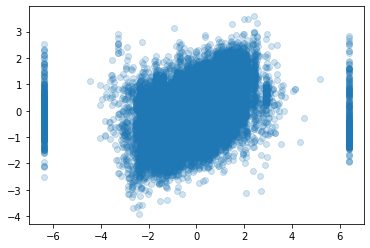

In [41]:
plt.scatter(np.array(tr_labels), np.array(B_zetas).dot(beta[0]), alpha = 0.2)

In [34]:
labels = np.array(labels)
B_zetas = np.array(B_zetas).reshape(95838, 10)
tr_labels = np.array(tr_labels)

In [42]:
np.save(str(extracted_coefficients_directory_Bzeta + 'labels_val.npy'), labels)
np.save(str(extracted_coefficients_directory_Bzeta + 'B_zeta_val.npy'), B_zetas)
np.save(str(extracted_coefficients_directory_Bzeta + 'tr_labels_val.npy'), tr_labels)

In [ ]:
B_zeta_labels = pd.DataFrame(data = {'label' : labels, 'Bzeta' : B_zetas, 'tr_label': tr_labels})

In [ ]:
B_zeta_labels.to_csv(str(extracted_coefficients_directory_Bzeta + 'bzeta_df.csv')) # save